# **Assignment 2**, **dataset 3**


# Problem statement



### Loading the dataset

The PlantVillage dataset contains 54,304 images. The images span 14 crop species: Apple, Blueberry, Cherry, Corn, Grape, Orange, Peach, Bell Pepper, Potato, Raspberry, Soybean, Squash, Strawberry, Tomato. In containes images of 17 fungal diseases, 4 bacterial diseases, 2 mold (oomycete) diseases, 2 viral disease, and 1 disease caused by a mite. 12 crop species also have images of healthy leaves that are not visibly affected by a disease.

https://arxiv.org/pdf/1511.08060

https://github.com/gabrieldgf4/PlantVillage-Dataset

For this assignment, you will make a model that predicts whether a bell pepper leaf comes from a healthy or unhealthy plant (binary classification). The healthy bell pepper leaf images are in the `Pepper,_bell___healthy` folder, while unhealthy cherry leaf images are in `Pepper,_bell___Bacterial_spot`. You are allowed to use a pretrained model that you transfer to this problem, if you whish so. Keep in mind that the dataset is somewhat uneven between the classes. Make sure to apply a technique to mitigate for that.

In [1]:
# Download the dataset
!git clone https://github.com/gabrieldgf4/PlantVillage-Dataset.git

fatal: destination path 'PlantVillage-Dataset' already exists and is not an empty directory.


In [2]:
# imports
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
import torchvision.transforms.functional as TF
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score
import numpy as np
import time
from tqdm import tqdm
from torchvision import models
import torch.nn as nn

## **Exploratory Data Analysis**

The student will have to make a written analysis of the data being loaded (depending on the dataset that was assigned to them). They should apply methods of inspecting the data and make some exploratory data analysis

In [3]:
DIR = "PlantVillage-Dataset"
#os.listdir('PlantVillage-Dataset') # We are only interested in the healthy and unhealthy bell pepper images
healthy_path = os.path.join(DIR, "Pepper,_bell___healthy")
unhealthy_path = os.path.join(DIR, "Pepper,_bell___Bacterial_spot")

First of all, we check our data distribution. We can see that we have more positive (healthy) than negative (unhealthy) examples; our dataset is thus imbalanced.

In [4]:
healthy_images = os.listdir(healthy_path)
unhealthy_images = os.listdir(unhealthy_path)
print("Healthy bell pepper images:", len(healthy_images))
print("Unhealthy bell pepper images:", len(unhealthy_images))
print("Total data set size:", len(healthy_images)+len(unhealthy_images))

Healthy bell pepper images: 1476
Unhealthy bell pepper images: 997
Total data set size: 2473


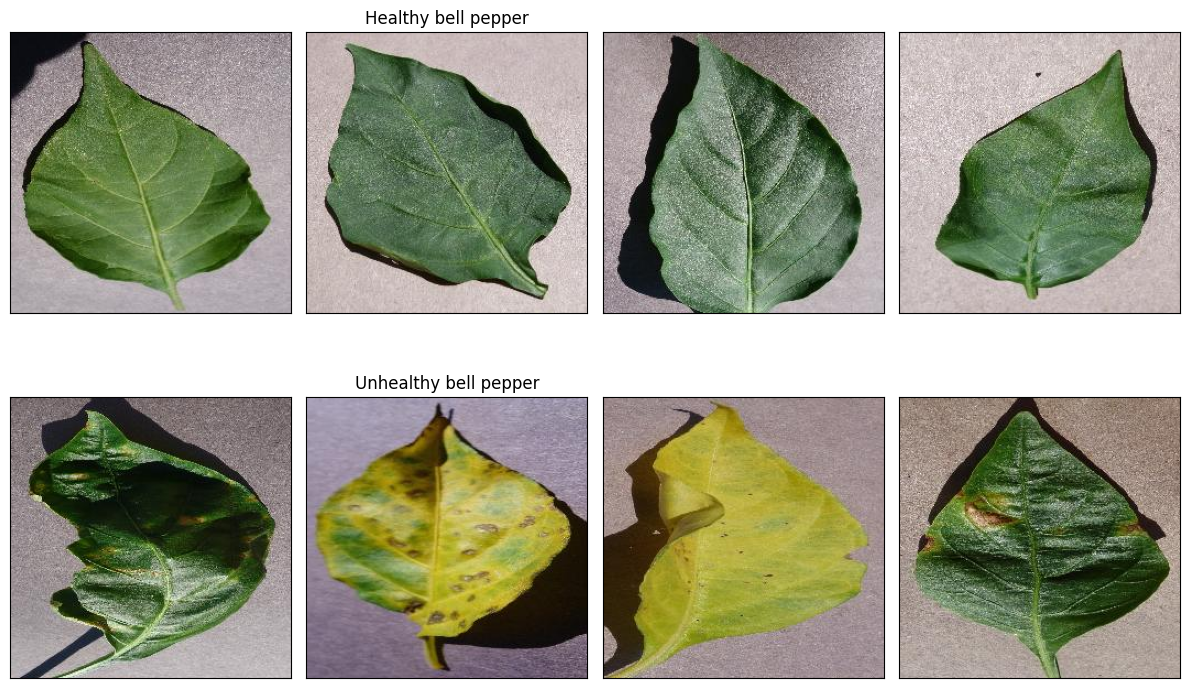

In [5]:
# inspect some examples for healthy and unhealthy bell peppers

healthy_images_sample = random.sample(healthy_images, 4)
unhealthy_images_sample = random.sample(unhealthy_images, 4)

plt.figure(figsize=(12, 8)) # code modified after Computer_vision_exercise_solutions.ipynb

for i, file_name in enumerate(healthy_images_sample):
  #print(file_name) # we have JPG images
  image = mpimg.imread(os.path.join(healthy_path,file_name))
  #print(image.shape) # (256, 256, 3) --> 256*256 pixels, colour images
  ax = plt.subplot(2, 4, i+1)
  plt.imshow(image)
  plt.axis('on')
  plt.xticks([])
  plt.yticks([])
  if i ==1:
    plt.title("Healthy bell pepper")


for i, file_name in enumerate(unhealthy_images_sample):
  image = mpimg.imread(os.path.join(unhealthy_path,file_name))
  ax = plt.subplot(2, 4, i+5)
  plt.imshow(image)
  plt.axis('on')
  plt.xticks([])
  plt.yticks([])
  if i ==1:
    plt.title("Unhealthy bell pepper")

plt.tight_layout()
plt.show()

## **Data Preprocessing**:

If applicable, the student will create new features from existing data to improve model performance and/or select the most relevant features for the model.

First, we have to create a Dataset from the images including their label (0 or 1 since we are dealing with a binary classification task here). In the getitem()method we then apply the transformations (here resizing to a size our resnet model can work with and a conversion to a tensor).

In [6]:
# cf. https://github.com/heraclex12/R-BERT-Relation-Classification/blob/master/BERT_for_Relation_Classification.ipynb, assessed Aug 6, 2025
def set_seed(seed):
    """Sets a random seed."""
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

set_seed(42)

# code modified from: https://docs.pytorch.org/tutorials/beginner/data_loading_tutorial.html, assessed Aug 2, 2025 and https://medium.com/bivek-adhikari/creating-custom-datasets-and-dataloaders-with-pytorch-7e9d2f06b660.

# define a transform
transform = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # data preprocessing for ResNet50 after https://pytorch.org/hub/pytorch_vision_resnet/
])

transform_augmented = transforms.Compose([ # see PRACTICE_1_image_augmentation_torch.ipynb
    transforms.RandomRotation(degrees=15), # rotate by 15 degrees
    transforms.RandomVerticalFlip(), # random horizontal flip
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
])

# create labels and merge images together
image_paths = []
labels = []

for fname in os.listdir(healthy_path):
    image_paths.append(os.path.join(healthy_path, fname))
    labels.append(1) # label 1 for healthy bell pepper

for fname in os.listdir(unhealthy_path):
    image_paths.append(os.path.join(unhealthy_path, fname))
    labels.append(0) # label 0 for unhealthy bell pepper


class BellPepperDataset(Dataset):
    """BellPepper Dataset."""

    def __init__(self, image_paths, labels, transform=None, transform_augmented=None):
        """
        Arguments:
            image_paths (list): List of image paths.
            labels (list): List of labels.
            transform (callable, optional): Optional transform to be applied on a sample. For the normal data set, we just resize and convert image to Tensor.
            transform_augmented (callable, optional): Optional transform to be applied on a sample of images to be augmented. Involves random rotation, random vertical flip and colorjitter.
        """
        self.transform = transform
        self.transform_augmented = transform_augmented
        self.image_paths = image_paths
        self.labels = labels
        self.augmented_images = []
        self.augmented_labels = []

    def oversample_minority_class_by_augmenting(self):
      if len(self.augmented_images) == 0:
        majority_count = self.labels.count(1) # we know that positive is the majority class
        minority_count = self.labels.count(0)
        needed = majority_count - minority_count

        print(f"Augmenting and oversampling dataset by {needed} negatives examples.")

        negative_indices = [i for i, label in enumerate(self.labels) if label == 0]

        for i in range(needed):
          idx = random.choice(negative_indices) # take a random negative image path
          image_path = self.image_paths[idx]
          image = Image.open(image_path).convert("RGB")
          if self.transform_augmented:
              image = self.transform_augmented(image)

          self.augmented_images.append(image)
          self.augmented_labels.append(0)

    def __len__(self):
        return len(self.image_paths) + len(self.augmented_images)

    def __getitem__(self, idx):
        if idx < len(self.image_paths):
          image_path = self.image_paths[idx]
          image = Image.open(image_path).convert("RGB")
          label = self.labels[idx]
          if self.transform:
            image = self.transform(image)
        else: # then we are dealing with a transformed image
          image = self.augmented_images[idx - len(self.image_paths)]
          label = self.augmented_labels[idx - len(self.image_paths)]

        return image, label


(tensor([[[0.7608, 0.7529, 0.7451,  ..., 0.6863, 0.7451, 0.6902],
         [0.7608, 0.7569, 0.7490,  ..., 0.6980, 0.7294, 0.7059],
         [0.7647, 0.7647, 0.7608,  ..., 0.6941, 0.6863, 0.7098],
         ...,
         [0.6118, 0.6235, 0.6353,  ..., 0.6118, 0.6078, 0.6235],
         [0.5961, 0.6118, 0.6275,  ..., 0.6118, 0.5647, 0.5333],
         [0.5882, 0.6039, 0.6196,  ..., 0.5098, 0.5412, 0.6078]],

        [[0.7490, 0.7412, 0.7333,  ..., 0.6667, 0.7255, 0.6706],
         [0.7490, 0.7451, 0.7373,  ..., 0.6784, 0.7098, 0.6863],
         [0.7529, 0.7529, 0.7490,  ..., 0.6745, 0.6667, 0.6902],
         ...,
         [0.5686, 0.5804, 0.5922,  ..., 0.5647, 0.5608, 0.5765],
         [0.5529, 0.5686, 0.5843,  ..., 0.5647, 0.5176, 0.4863],
         [0.5451, 0.5608, 0.5765,  ..., 0.4627, 0.4941, 0.5608]],

        [[0.7765, 0.7686, 0.7608,  ..., 0.6941, 0.7529, 0.6980],
         [0.7765, 0.7725, 0.7647,  ..., 0.7059, 0.7373, 0.7137],
         [0.7804, 0.7804, 0.7765,  ..., 0.7020, 0.6941, 0

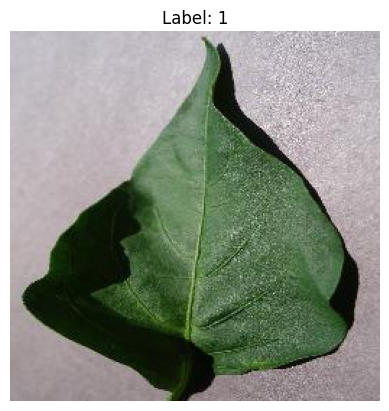

In [7]:
dataset = BellPepperDataset(image_paths, labels, transform, transform_augmented) # sanity check
print(dataset[0])
import torchvision.transforms.functional as TF

image, label = dataset[0]
plt.imshow(TF.to_pil_image(image))
plt.title(f"Label: {label}")
plt.axis("off")
plt.show()

## **Data Transformation**

The student should prepare the data for the training. Augmenting, splitting, and otherwise transforming should be done here.

#### Note that data augmentation is performed under Results in order to compare performance for a model trained on balanced and augmented data and imbalanced data.

In [8]:
set_seed(42)

# split data set paths into train, val, test (80-10-10 split)
paths_train, paths_temp, labels_train, labels_temp = train_test_split(image_paths, labels, test_size=0.2, random_state=42)

paths_eval, paths_test, labels_eval, labels_test = train_test_split(paths_temp, labels_temp, test_size=0.5, random_state=42)

# create the datasets (training with oversampling via augmentation to balance classes)
data_train = BellPepperDataset(paths_train, labels_train, transform=transform, transform_augmented=transform_augmented)

print("Size of training data before augmenting:", len(data_train))

data_eval = BellPepperDataset(paths_eval, labels_eval, transform=transform)

data_test = BellPepperDataset(paths_test, labels_test, transform=transform)

# data augmentation for training set
#data_train.oversample_minority_class_by_augmenting()

#print("Size of training data after augmenting:", len(data_train))

# code modified from Computer_vision_exercise_solutions.ipynb
loaders = {
    'train' : torch.utils.data.DataLoader(data_train,
                                        batch_size=10,
                                        shuffle=True,
                                        num_workers=0),

    'validation'  : torch.utils.data.DataLoader(data_eval,
                                        batch_size=10,
                                        shuffle=True,
                                        num_workers=0),
    'test'  : torch.utils.data.DataLoader(data_test,
                                        batch_size=3,
                                        shuffle=False,
                                        num_workers=0),
}

print(len(data_train))
print(len(data_eval))
print(len(data_test))

Size of training data before augmenting: 1978
1978
247
248


## **Model Selection**


The student should implement a simple model as a baseline to compare more complex models. The student should try more complex modes and justify their rejection or acceptance.

### Baseline

As a baseline, I choose a simple and early CNN: LeNet (LeCun et al.,2002). The LeNet architecture here is composed of only 2 convolutional layers, followed by average pooling, and three fully connected layers. The last linear layer outputs a single logit used for binary classification (cf. Géron 2022: 463).

In [9]:
# baseline: LeNet, code modified after Computer_vision_exercise_solutions.ipynb and Géron 2022:463
set_seed(42)

baseline_model = nn.Sequential(
    nn.Conv2d(3, 6, kernel_size=5, padding=2), nn.Sigmoid(), # colour image with 3 channels
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(16 * 62 * 62, 120), nn.Sigmoid(),
    nn.Linear(120, 84), nn.Sigmoid(),
    nn.Linear(84, 1) # binary classification
)

print(baseline_model)
# input (batch_size, 3, 256, 256)

# weight initialization, cf. Computer_vision_exercise_solutions.ipynb
def weights_init_uniform_rule(m):
    classname = m.__class__.__name__
    # for every Linear layer in a model..
    if classname.find('Linear') != -1:
        # get the number of the inputs
        n = m.in_features
        y = 1.0/np.sqrt(n)
        m.weight.data.uniform_(-y, y)
        m.bias.data.fill_(0)

baseline_model.apply(weights_init_uniform_rule)

Sequential(
  (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): Sigmoid()
  (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (4): Sigmoid()
  (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=61504, out_features=120, bias=True)
  (8): Sigmoid()
  (9): Linear(in_features=120, out_features=84, bias=True)
  (10): Sigmoid()
  (11): Linear(in_features=84, out_features=1, bias=True)
)


Sequential(
  (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): Sigmoid()
  (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (4): Sigmoid()
  (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=61504, out_features=120, bias=True)
  (8): Sigmoid()
  (9): Linear(in_features=120, out_features=84, bias=True)
  (10): Sigmoid()
  (11): Linear(in_features=84, out_features=1, bias=True)
)

### Transfer Learning with a pre-trained model

As a more complex model, I finetuned only the classification head of a pre-trained ResNet50 from torch vision models, while keeping the remaining layers frozen. ResNet50 is a more modern, deep CNN with 50 layers, using residual connections, which is pre-trained on a large dataset (ImageNet) to learn rich features. (cf. Zhang et al. 2016).

In [10]:
set_seed(42)

# build own classifier with ResNet backbone/feature extractor
class CustomResNetModel(nn.Module):
    def __init__(self):
        super(CustomResNetModel, self).__init__()
        self.base_model = models.resnet50(pretrained=True) # ResNet50 backbone (pre-trained)

        for param in self.base_model.parameters(): # freeze all parameters, we only want to finetune the classification head
            param.requires_grad = False

        num_features = self.base_model.fc.in_features # modified after https://rumn.medium.com/part-1-ultimate-guide-to-fine-tuning-in-pytorch-pre-trained-model-and-its-configuration-8990194b71e
        self.base_model.fc = nn.Linear(num_features, 1)  # binary classification

    def forward(self, x):
        return self.base_model(x)

resnet_model = CustomResNetModel()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet_model = resnet_model.to(device)
print(resnet_model)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


CustomResNetModel(
  (base_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequentia

### Training function

In [11]:
# code for training loop modified after https://docs.pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html and Computer_vision_exercise_solutions.ipynb
def training_loop_simple(num_epochs, model, loaders, loss_f, optimizer, folder):
    loss_train = []
    loss_valid = []
    acc_train = []
    acc_val = []
    training_time = []
    min_valid_loss = np.inf

    model.to(device)

    for epoch in range(num_epochs):
        time_epoch_start = time.time()

        # Train the model
        model.train()
        epoch_train_loss = 0.0
        epoch_train_acc = 0.0

        for i, (images, labels) in tqdm(enumerate(loaders['train']), total=len(loaders['train'])):
            images, labels = images.to(device), labels.float().unsqueeze(1).to(device) # BCEWithLogitLoss() needs floating point labels, unsqueeze(1) adds a dimension so there is not a mismatch between output and labels
            # print(images.shape)
            # print(labels.shape)
            optimizer.zero_grad()
            output = model(images)
            loss = loss_f(output, labels)
            loss.backward()
            optimizer.step()

            epoch_train_loss += loss.item()

            probs = torch.sigmoid(output)
            preds = (probs > 0.5).float()
            correct = (preds == labels).float().sum()
            # print(correct)
            epoch_train_acc += (correct / labels.size(0)).item()

        avg_train_loss = epoch_train_loss / len(loaders['train'])
        avg_train_acc = epoch_train_acc / len(loaders['train'])

        # Validation phase
        model.eval()
        epoch_val_loss = 0.0
        epoch_val_acc = 0.0

        with torch.no_grad():
            for i, (images_v, labels_v) in tqdm(enumerate(loaders['validation']), total=len(loaders['validation'])):
                images_v, labels_v = images_v.to(device), labels_v.float().unsqueeze(1).to(device)
                output = model(images_v)
                loss_v = loss_f(output, labels_v)
                epoch_val_loss += loss_v.item()

                probs = torch.sigmoid(output)
                preds = (probs > 0.5).float()
                correct = (preds == labels_v).float().sum()
                epoch_val_acc += (correct / labels_v.size(0)).item() # CHECK SOURCE

        avg_val_loss = epoch_val_loss / len(loaders['validation'])
        avg_val_acc = epoch_val_acc / len(loaders['validation'])

        time_epoch_end = time.time()
        epoch_time = time_epoch_end - time_epoch_start

        print(f'Epoch {epoch+1}')
        print(f'Training Loss: {avg_train_loss:.4f}, Training Acc: {avg_train_acc:.4f}')
        print(f'Validation Loss: {avg_val_loss:.4f}, Validation Acc: {avg_val_acc:.4f}')
        print('-------------------')

        loss_train.append(avg_train_loss)
        loss_valid.append(avg_val_loss)
        acc_train.append(avg_train_acc)
        acc_val.append(avg_val_acc)
        training_time.append(epoch_time)

        if min_valid_loss > avg_val_loss:
            print(f'Validation Loss Decreased ({min_valid_loss:.4f} --> {avg_val_loss:.4f}) \t Saving The Model')
            min_valid_loss = avg_val_loss
            torch.save(model.state_dict(), os.path.join(folder, 'saved_model.pth'))

    print(f"Average training time per epoch on {device}:", round((sum(training_time) / len(training_time)),2), "seconds")
    print("Total training time:", round(sum((training_time)),2), "seconds")

    return loss_train, loss_valid, acc_train, acc_val


def plot_training_curves(loss_train, loss_valid, acc_train, acc_val):

  """
  Plots training and validation loss and accuracy over epochs.
  """
  fig, axs = plt.subplots(1, 2, figsize=(12, 5))

  # loss
  axs[0].plot(range(len(loss_train)), loss_train, label='train')
  axs[0].plot(range(len(loss_valid)), loss_valid, label='valid', color='magenta')
  axs[0].set_title('Loss')
  axs[0].set_xlabel('Epoch')
  axs[0].set_ylabel('Loss')
  axs[0].legend()

  # accuracy
  axs[1].plot(range(len(acc_train)), acc_train, label='train')
  axs[1].plot(range(len(acc_val)), acc_val, label='valid', color='magenta')
  axs[1].set_title('Accuracy')
  axs[1].set_xlabel('Epoch')
  axs[1].set_ylabel('Accuracy')
  axs[1].legend()

  plt.tight_layout()
  plt.show()

### Train the baseline model

cuda


100%|██████████| 25/25 [00:00<00:00, 61.29it/s]


Epoch 1
Training Loss: 0.6791, Training Acc: 0.5870
Validation Loss: 0.6613, Validation Acc: 0.6263
-------------------
Validation Loss Decreased (inf --> 0.6613) 	 Saving The Model


100%|██████████| 25/25 [00:00<00:00, 60.05it/s]


Epoch 2
Training Loss: 0.6792, Training Acc: 0.5941
Validation Loss: 0.6674, Validation Acc: 0.6246
-------------------


100%|██████████| 25/25 [00:00<00:00, 58.59it/s]


Epoch 3
Training Loss: 0.6766, Training Acc: 0.5942
Validation Loss: 0.6660, Validation Acc: 0.6263
-------------------


100%|██████████| 25/25 [00:00<00:00, 59.44it/s]


Epoch 4
Training Loss: 0.6777, Training Acc: 0.5941
Validation Loss: 0.6651, Validation Acc: 0.6194
-------------------


100%|██████████| 25/25 [00:00<00:00, 59.48it/s]


Epoch 5
Training Loss: 0.6770, Training Acc: 0.5939
Validation Loss: 0.6633, Validation Acc: 0.6229
-------------------


100%|██████████| 25/25 [00:00<00:00, 60.92it/s]


Epoch 6
Training Loss: 0.6767, Training Acc: 0.5943
Validation Loss: 0.6609, Validation Acc: 0.6263
-------------------
Validation Loss Decreased (0.6613 --> 0.6609) 	 Saving The Model


100%|██████████| 25/25 [00:00<00:00, 59.68it/s]


Epoch 7
Training Loss: 0.6788, Training Acc: 0.5939
Validation Loss: 0.6628, Validation Acc: 0.6229
-------------------


100%|██████████| 25/25 [00:00<00:00, 56.94it/s]


Epoch 8
Training Loss: 0.6779, Training Acc: 0.5942
Validation Loss: 0.6663, Validation Acc: 0.6229
-------------------


100%|██████████| 25/25 [00:00<00:00, 61.08it/s]


Epoch 9
Training Loss: 0.6774, Training Acc: 0.5938
Validation Loss: 0.6634, Validation Acc: 0.6263
-------------------


100%|██████████| 25/25 [00:00<00:00, 58.88it/s]


Epoch 10
Training Loss: 0.6768, Training Acc: 0.5939
Validation Loss: 0.6704, Validation Acc: 0.6263
-------------------
Average training time per epoch on cuda: 5.51 seconds
Total training time: 55.05 seconds


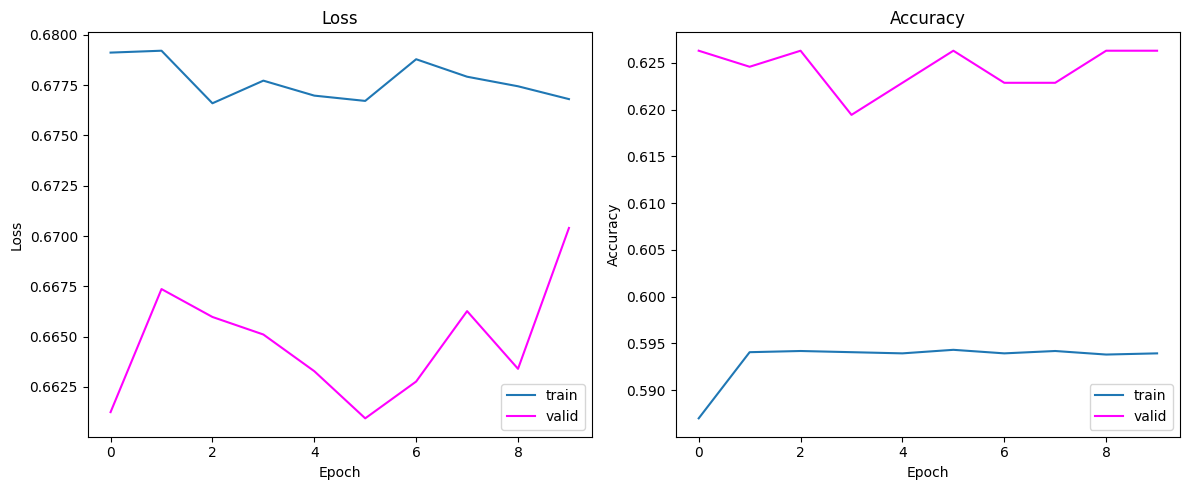

In [12]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(baseline_model.parameters(), lr=0.001)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
set_seed(42)

folder = './models_baseline'
os.makedirs(folder, exist_ok=True)

loss_train, loss_valid, acc_train, acc_val = training_loop_simple(
    num_epochs=10,
    model=baseline_model,
    loaders=loaders,
    loss_f=criterion,
   optimizer=optimizer,
    folder=folder
)

plot_training_curves(loss_train, loss_valid, acc_train, acc_val)

We can see from the training and validation plots that the LeNet model is not learning. While the training loss decreases very slightly, the validation loss is fluctuating and increasing. Furthermore, the training accuracy is only increasing in the first epoch before reaching a pleateau, while the validation accuracy is only fluctuating. While the Sigmoid activation function in the LeNet architecture was used for the MNIST dataset and yielded to decreasing loss for both the training and validation set (see Computer_vision_exercise_solutions.ipynb), colour images of size 256x256 might be too complex inputs, potentially leading to vanishing gradients, ultimately preventing the model from learning (Géron 2022: 333f.).

Sequential(
  (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): ReLU()
  (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (4): ReLU()
  (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=61504, out_features=120, bias=True)
  (8): ReLU()
  (9): Linear(in_features=120, out_features=84, bias=True)
  (10): ReLU()
  (11): Linear(in_features=84, out_features=1, bias=True)
)
cuda


100%|██████████| 25/25 [00:00<00:00, 60.48it/s]


Epoch 1
Training Loss: 0.5512, Training Acc: 0.7402
Validation Loss: 0.3659, Validation Acc: 0.8189
-------------------
Validation Loss Decreased (inf --> 0.3659) 	 Saving The Model


100%|██████████| 25/25 [00:00<00:00, 60.17it/s]


Epoch 2
Training Loss: 0.3026, Training Acc: 0.8692
Validation Loss: 0.1801, Validation Acc: 0.9160
-------------------
Validation Loss Decreased (0.3659 --> 0.1801) 	 Saving The Model


100%|██████████| 25/25 [00:00<00:00, 59.10it/s]


Epoch 3
Training Loss: 0.1818, Training Acc: 0.9287
Validation Loss: 0.2890, Validation Acc: 0.8806
-------------------


100%|██████████| 25/25 [00:00<00:00, 61.05it/s]


Epoch 4
Training Loss: 0.1359, Training Acc: 0.9530
Validation Loss: 0.0944, Validation Acc: 0.9760
-------------------
Validation Loss Decreased (0.1801 --> 0.0944) 	 Saving The Model


100%|██████████| 25/25 [00:00<00:00, 61.18it/s]


Epoch 5
Training Loss: 0.0787, Training Acc: 0.9701
Validation Loss: 0.1379, Validation Acc: 0.9480
-------------------


100%|██████████| 25/25 [00:00<00:00, 59.58it/s]


Epoch 6
Training Loss: 0.0658, Training Acc: 0.9788
Validation Loss: 0.0995, Validation Acc: 0.9640
-------------------


100%|██████████| 25/25 [00:00<00:00, 58.56it/s]


Epoch 7
Training Loss: 0.0467, Training Acc: 0.9832
Validation Loss: 0.1896, Validation Acc: 0.9400
-------------------


100%|██████████| 25/25 [00:00<00:00, 59.02it/s]


Epoch 8
Training Loss: 0.0366, Training Acc: 0.9898
Validation Loss: 0.1103, Validation Acc: 0.9680
-------------------


100%|██████████| 25/25 [00:00<00:00, 55.82it/s]


Epoch 9
Training Loss: 0.0615, Training Acc: 0.9798
Validation Loss: 0.0913, Validation Acc: 0.9680
-------------------
Validation Loss Decreased (0.0944 --> 0.0913) 	 Saving The Model


100%|██████████| 25/25 [00:00<00:00, 60.06it/s]


Epoch 10
Training Loss: 0.0992, Training Acc: 0.9697
Validation Loss: 0.3566, Validation Acc: 0.9149
-------------------
Average training time per epoch on cuda: 5.52 seconds
Total training time: 55.17 seconds


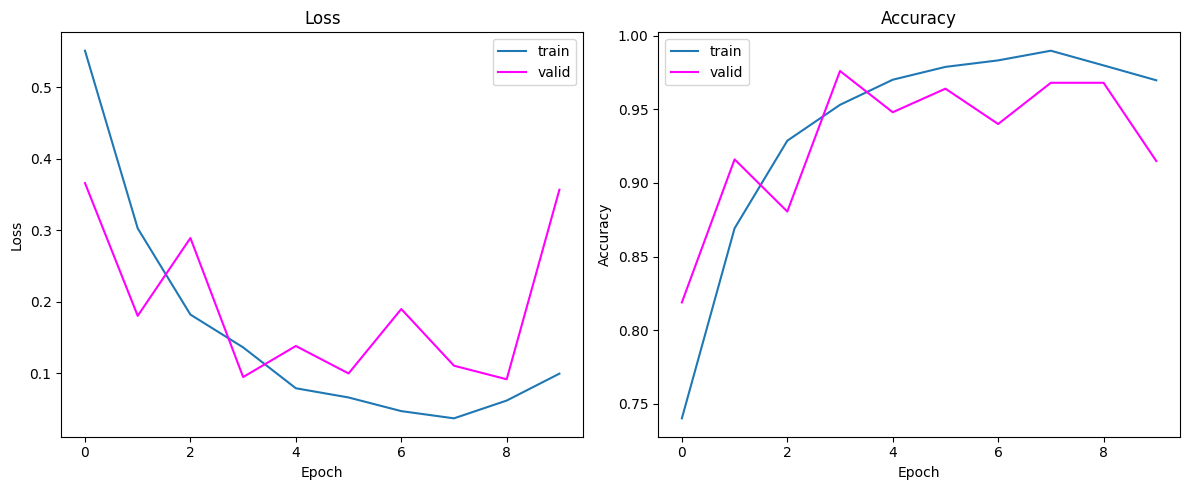

In [13]:
# baseline: LeNet, code modified after Computer_vision_exercise_solutions.ipynb and Géron 2022:463 (LeNet/RELU/NO AUG)
set_seed(42)

baseline_model = nn.Sequential(
    nn.Conv2d(3, 6, kernel_size=5, padding=2), nn.ReLU(), # colour image with 3 channels
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.ReLU(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(16 * 62 * 62, 120), nn.ReLU(),
    nn.Linear(120, 84), nn.ReLU(),
    nn.Linear(84, 1) # binary classification
)

print(baseline_model)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(baseline_model.parameters(), lr=0.001)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

folder = './models_baseline_relu'
os.makedirs(folder, exist_ok=True)

loss_train, loss_valid, acc_train, acc_val = training_loop_simple(
    num_epochs=10,
    model=baseline_model,
    loaders=loaders,
    loss_f=criterion,
   optimizer=optimizer,
    folder=folder
)

plot_training_curves(loss_train, loss_valid, acc_train, acc_val)

In the plots above we can see that only changing the activation function to ReLU yields a decreasing training loss and high training and validation accuracy. While the validation loss initially decreases, it fluctuates heavily and increases again, with validation accuracy also being subject to heavy fluctuations, while staying below the training accuracy. This can be interpreted as a sign of overfitting, which could be mitigated by data augmentation and to add dropout or weight regularization (cf. Chollet 2021:104ff.).

### Finetune the pre-trained model

cuda


100%|██████████| 25/25 [00:01<00:00, 21.50it/s]


Epoch 1
Training Loss: 0.3386, Training Acc: 0.8768
Validation Loss: 0.1402, Validation Acc: 0.9720
-------------------
Validation Loss Decreased (inf --> 0.1402) 	 Saving The Model


100%|██████████| 25/25 [00:01<00:00, 21.53it/s]


Epoch 2
Training Loss: 0.1775, Training Acc: 0.9460
Validation Loss: 0.1103, Validation Acc: 0.9600
-------------------
Validation Loss Decreased (0.1402 --> 0.1103) 	 Saving The Model


100%|██████████| 25/25 [00:01<00:00, 21.39it/s]


Epoch 3
Training Loss: 0.1565, Training Acc: 0.9455
Validation Loss: 0.0614, Validation Acc: 0.9880
-------------------
Validation Loss Decreased (0.1103 --> 0.0614) 	 Saving The Model


100%|██████████| 25/25 [00:01<00:00, 21.32it/s]


Epoch 4
Training Loss: 0.1401, Training Acc: 0.9475
Validation Loss: 0.0621, Validation Acc: 0.9840
-------------------


100%|██████████| 25/25 [00:01<00:00, 21.36it/s]


Epoch 5
Training Loss: 0.1225, Training Acc: 0.9591
Validation Loss: 0.0450, Validation Acc: 0.9960
-------------------
Validation Loss Decreased (0.0614 --> 0.0450) 	 Saving The Model


100%|██████████| 25/25 [00:01<00:00, 21.25it/s]


Epoch 6
Training Loss: 0.1141, Training Acc: 0.9596
Validation Loss: 0.0402, Validation Acc: 0.9960
-------------------
Validation Loss Decreased (0.0450 --> 0.0402) 	 Saving The Model


100%|██████████| 25/25 [00:01<00:00, 21.36it/s]


Epoch 7
Training Loss: 0.1228, Training Acc: 0.9566
Validation Loss: 0.0340, Validation Acc: 0.9960
-------------------
Validation Loss Decreased (0.0402 --> 0.0340) 	 Saving The Model


100%|██████████| 25/25 [00:01<00:00, 21.18it/s]


Epoch 8
Training Loss: 0.1080, Training Acc: 0.9590
Validation Loss: 0.0351, Validation Acc: 0.9920
-------------------


100%|██████████| 25/25 [00:01<00:00, 21.27it/s]


Epoch 9
Training Loss: 0.1096, Training Acc: 0.9616
Validation Loss: 0.0278, Validation Acc: 0.9960
-------------------
Validation Loss Decreased (0.0340 --> 0.0278) 	 Saving The Model


100%|██████████| 25/25 [00:01<00:00, 21.27it/s]


Epoch 10
Training Loss: 0.1059, Training Acc: 0.9591
Validation Loss: 0.0298, Validation Acc: 0.9920
-------------------
Average training time per epoch on cuda: 11.13 seconds
Total training time: 111.35 seconds


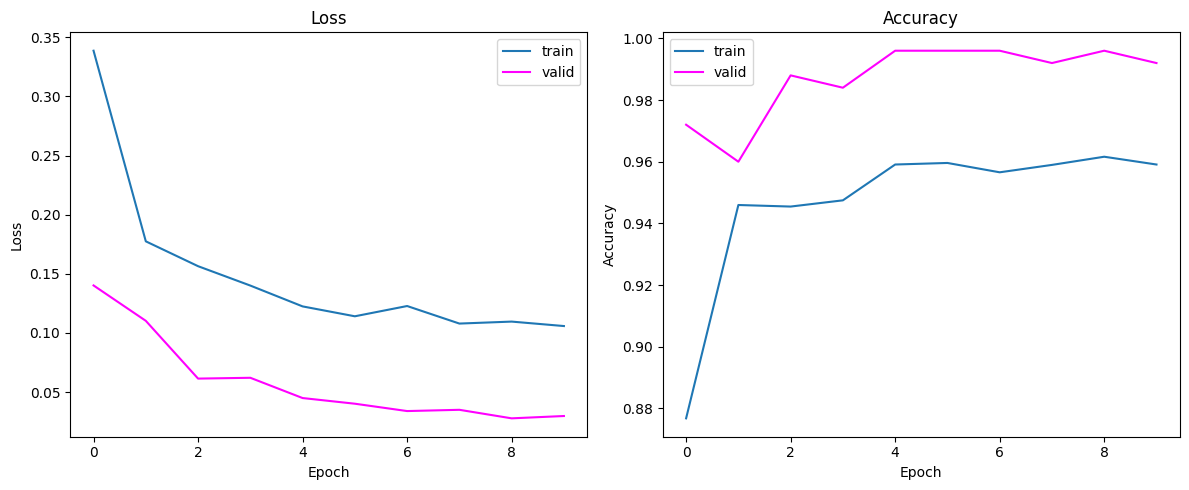

In [14]:
set_seed(42)

criterion = nn.BCEWithLogitsLoss() # code for training loop modified after https://docs.pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html and Computer_vision_exercise_solutions.ipynb
optimizer = torch.optim.Adam(resnet_model.parameters(), lr=0.001)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

folder_resnet = './models_resnet'
os.makedirs(folder_resnet, exist_ok=True)

loss_train, loss_valid, acc_train, acc_val = training_loop_simple(
    num_epochs=10,
    model=resnet_model,
    loaders=loaders,
    loss_f=criterion,
    optimizer=optimizer,
    folder=folder_resnet
)
plot_training_curves(loss_train, loss_valid, acc_train, acc_val)

We can see from the plots above for the pre-trained ResNet model that both validation and training loss are decreasing and accuracy is increasing (though fluctuating after the first epoch). Generally, validation loss is lower than training loss and validation accuracy is higher than training accuracy, indicating that the model is generalizing well and no signs of overfitting can be detected. The training time, however, is doubled compared to training the LeNet architecture on our dataset from scratch.

## **Reporting the results**

The student should report the results. Identify which features are most influential in the model’s predictions, if applicable for the dataset and model used.

In [15]:
# Code modified after Computer_vision_exercise_solutions.ipynb
def evaluate(model, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    all_preds = []
    all_labels = []

    correct = 0
    total = 0

    with torch.no_grad():
        for test_imgs, test_labels in test_loader:
            test_imgs, test_labels = test_imgs.to(device), test_labels.float().unsqueeze(1).to(device)
            output = model(test_imgs)
            probs = torch.sigmoid(output)
            preds = (probs > 0.5).float()
            correct += (preds == test_labels).sum().item()
            total += test_labels.size(0)

            all_preds.extend(preds.cpu().numpy().flatten())
            all_labels.extend(test_labels.cpu().numpy().flatten())


    accuracy = correct / total
    f1 = f1_score(all_labels, all_preds)
    print(f"Test accuracy: {accuracy:.3f}")
    print(f"Test F1 Score: {f1:.3f}")



def evaluate_confusion_matrix(model: nn.Module, test_loader) -> np.ndarray:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    lbl_pred = []
    lbl_test = []

    with torch.no_grad():
        for test_imgs, test_labels in test_loader:
            test_imgs, test_labels = test_imgs.to(device), test_labels.float().unsqueeze(1).to(device)
            output = model(test_imgs)
            probs = torch.sigmoid(output)
            preds = (probs > 0.5).float()

            lbl_pred.extend(preds.cpu().numpy().flatten())
            lbl_test.extend(test_labels.cpu().numpy().flatten())

    cm = confusion_matrix(lbl_test, lbl_pred)
    return cm

#### LeNet model with relu (and without data augmentation)

Test accuracy: 0.956
Test F1 Score: 0.962


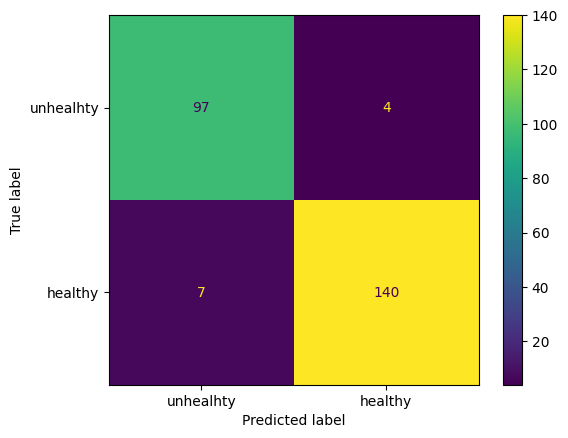

In [16]:
baseline_model.load_state_dict(torch.load('./models_baseline_relu/saved_model.pth')) # LeNet/RELU/NO AUG
evaluate(baseline_model, loaders['test'])

cm = evaluate_confusion_matrix(baseline_model, loaders['test'])
cm_plot = ConfusionMatrixDisplay(cm, display_labels=['unhealhty', 'healthy'])
cm_plot.plot()

#### ResNet model (without data augmentation)

Test accuracy: 0.984
Test F1 Score: 0.986


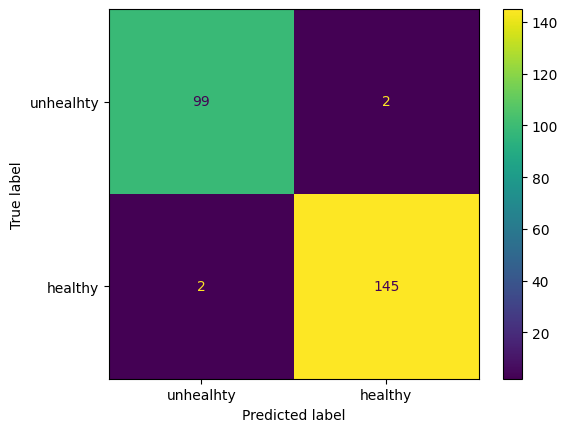

In [17]:
resnet_model.load_state_dict(torch.load('./models_resnet/saved_model.pth'))
evaluate(resnet_model, loaders['test'])
cm = evaluate_confusion_matrix(resnet_model, loaders['test'])
cm_plot = ConfusionMatrixDisplay(cm, display_labels=['unhealhty', 'healthy'])
cm_plot.plot()

Comparing the performance of the baseline model (LeNet with ReLU activation function) and the pre-trained ResNet50 model, the latter yields a slightly higher accuracy and F1 score on the test set (test accuracy of 0.984 vs. 0.956 and F1 score of 0.986 vs. 0.962). In two cases it misclassifies a healthy leaf as unhealthy, and in two cases it predicts the label "heathy" for an unhealthy leaf. The LeNet model misclassifies more images, but still yields high performance. Given the class imbalance, the F1 score was reported as it is more robust towards class imbalances as accuracy. We can observe that even though we are dealing with class imbalances, the models perform well and we cannot observe a bias towards predicting the majority (healthy) class.
Given the doubled training time, however, the differences in performance are subtle, with both models reaching very high accuracies and F1 scores. This might be due to the simplicity of the task: First, we are dealing with binary classification, and secondly, the features indicating an unhealthy leaf are, as observed during the data exploration above, usually brown spots on the leaf, making the problem at hand rather easy.

### Does data augmentation improve model performance?

In [18]:
set_seed(42)

print("Size of training data before augmenting:", len(data_train))

# data augmentation for training set
data_train.oversample_minority_class_by_augmenting()

print("Size of training data after augmenting:", len(data_train))

# code modified from Computer_vision_exercise_solutions.ipynb
loaders = {
    'train' : torch.utils.data.DataLoader(data_train,
                                        batch_size=10,
                                        shuffle=True,
                                        num_workers=0),

    'validation'  : torch.utils.data.DataLoader(data_eval,
                                        batch_size=10,
                                        shuffle=True,
                                        num_workers=0),
    'test'  : torch.utils.data.DataLoader(data_test,
                                        batch_size=3,
                                        shuffle=False,
                                        num_workers=0),
}

print()
print(len(data_train))
print(len(data_eval))
print(len(data_test))

Size of training data before augmenting: 1978
Augmenting and oversampling dataset by 372 negatives examples.
Size of training data after augmenting: 2350

2350
247
248


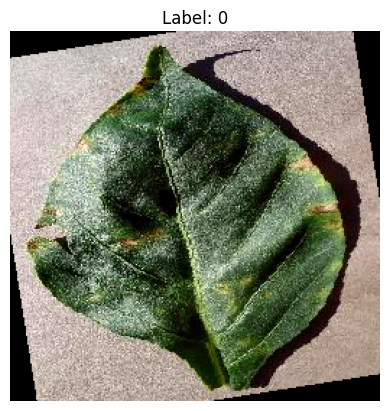

In [19]:
image, label = data_train[len(data_train)-1] # have a look at one augmented image (unhealthy bell pepper)
plt.imshow(TF.to_pil_image(image))
plt.title(f"Label: {label}")
plt.axis("off")
plt.show()

100%|██████████| 25/25 [00:00<00:00, 61.80it/s]


Epoch 1
Training Loss: 0.3672, Training Acc: 0.8209
Validation Loss: 0.2508, Validation Acc: 0.8851
-------------------
Validation Loss Decreased (inf --> 0.2508) 	 Saving The Model


100%|██████████| 25/25 [00:00<00:00, 57.14it/s]


Epoch 2
Training Loss: 0.2295, Training Acc: 0.9098
Validation Loss: 0.2021, Validation Acc: 0.9360
-------------------
Validation Loss Decreased (0.2508 --> 0.2021) 	 Saving The Model


100%|██████████| 25/25 [00:00<00:00, 61.13it/s]


Epoch 3
Training Loss: 0.1057, Training Acc: 0.9630
Validation Loss: 0.1412, Validation Acc: 0.9480
-------------------
Validation Loss Decreased (0.2021 --> 0.1412) 	 Saving The Model


100%|██████████| 25/25 [00:00<00:00, 61.89it/s]


Epoch 4
Training Loss: 0.1549, Training Acc: 0.9451
Validation Loss: 0.1886, Validation Acc: 0.9320
-------------------


100%|██████████| 25/25 [00:00<00:00, 60.17it/s]


Epoch 5
Training Loss: 0.1143, Training Acc: 0.9549
Validation Loss: 0.1842, Validation Acc: 0.9320
-------------------


100%|██████████| 25/25 [00:00<00:00, 61.81it/s]


Epoch 6
Training Loss: 0.0681, Training Acc: 0.9740
Validation Loss: 0.1350, Validation Acc: 0.9440
-------------------
Validation Loss Decreased (0.1412 --> 0.1350) 	 Saving The Model


100%|██████████| 25/25 [00:00<00:00, 59.92it/s]


Epoch 7
Training Loss: 0.0233, Training Acc: 0.9928
Validation Loss: 0.1763, Validation Acc: 0.9440
-------------------


100%|██████████| 25/25 [00:00<00:00, 60.32it/s]


Epoch 8
Training Loss: 0.0337, Training Acc: 0.9872
Validation Loss: 0.1341, Validation Acc: 0.9720
-------------------
Validation Loss Decreased (0.1350 --> 0.1341) 	 Saving The Model


100%|██████████| 25/25 [00:00<00:00, 60.47it/s]


Epoch 9
Training Loss: 0.0120, Training Acc: 0.9966
Validation Loss: 0.2750, Validation Acc: 0.9520
-------------------


100%|██████████| 25/25 [00:00<00:00, 62.81it/s]


Epoch 10
Training Loss: 0.0164, Training Acc: 0.9962
Validation Loss: 0.3178, Validation Acc: 0.9286
-------------------
Average training time per epoch on cuda: 6.01 seconds
Total training time: 60.1 seconds


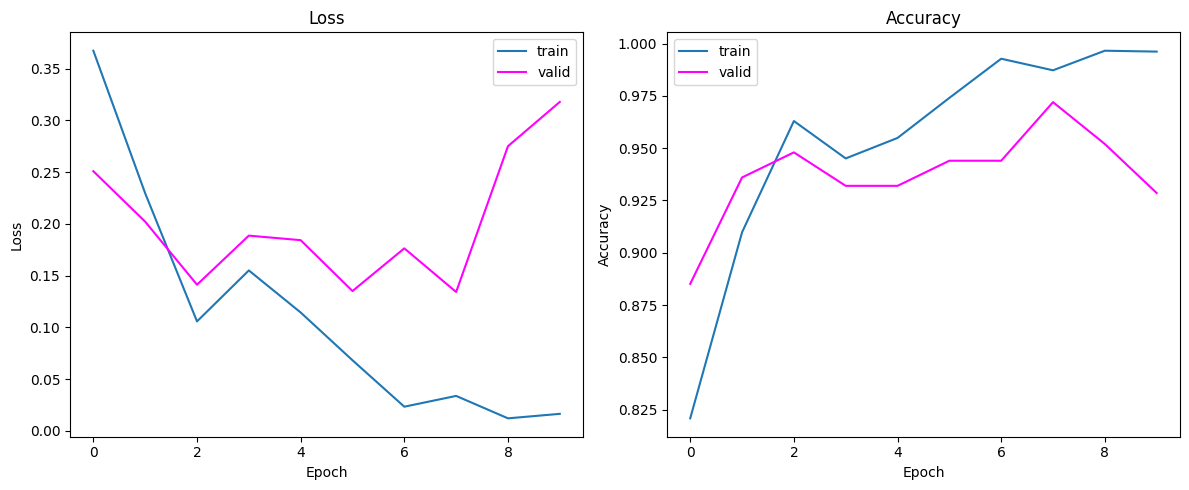

Test accuracy: 0.927
Test F1 Score: 0.941


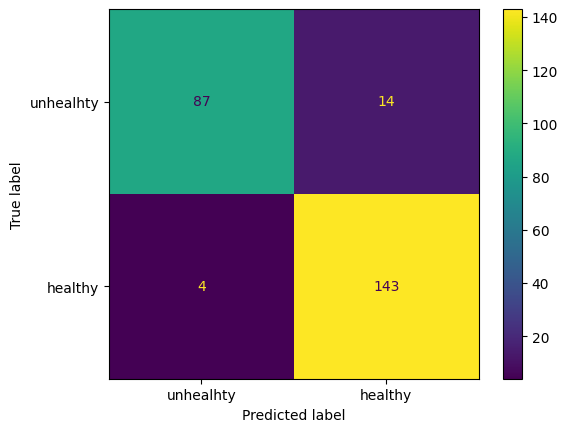

In [20]:
set_seed(42) # (LeNet/RELU/AUG)

baseline_model = nn.Sequential(
    nn.Conv2d(3, 6, kernel_size=5, padding=2), nn.ReLU(), # colour image with 3 channels
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.ReLU(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(16 * 62 * 62, 120), nn.ReLU(),
    nn.Linear(120, 84), nn.ReLU(),
    nn.Linear(84, 1) # binary classification
)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(baseline_model.parameters(), lr=0.001)

folder = './models_baseline_relu_data_augmentation'
os.makedirs(folder, exist_ok=True)

loss_train, loss_valid, acc_train, acc_val = training_loop_simple(
    num_epochs=10,
    model=baseline_model,
    loaders=loaders,
    loss_f=criterion,
   optimizer=optimizer,
    folder=folder
)

plot_training_curves(loss_train, loss_valid, acc_train, acc_val)

baseline_model.load_state_dict(torch.load('./models_baseline_relu_data_augmentation/saved_model.pth'))
evaluate(baseline_model, loaders['test'])
cm = evaluate_confusion_matrix(baseline_model, loaders['test'])
cm_plot = ConfusionMatrixDisplay(cm, display_labels=['unhealhty', 'healthy'])
cm_plot.plot()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 25/25 [00:01<00:00, 21.02it/s]


Epoch 1
Training Loss: 0.3061, Training Acc: 0.8945
Validation Loss: 0.1238, Validation Acc: 0.9920
-------------------
Validation Loss Decreased (inf --> 0.1238) 	 Saving The Model


100%|██████████| 25/25 [00:01<00:00, 21.23it/s]


Epoch 2
Training Loss: 0.1869, Training Acc: 0.9311
Validation Loss: 0.0831, Validation Acc: 0.9880
-------------------
Validation Loss Decreased (0.1238 --> 0.0831) 	 Saving The Model


100%|██████████| 25/25 [00:01<00:00, 21.23it/s]


Epoch 3
Training Loss: 0.1475, Training Acc: 0.9413
Validation Loss: 0.0573, Validation Acc: 0.9880
-------------------
Validation Loss Decreased (0.0831 --> 0.0573) 	 Saving The Model


100%|██████████| 25/25 [00:01<00:00, 20.98it/s]


Epoch 4
Training Loss: 0.1277, Training Acc: 0.9540
Validation Loss: 0.0471, Validation Acc: 0.9880
-------------------
Validation Loss Decreased (0.0573 --> 0.0471) 	 Saving The Model


100%|██████████| 25/25 [00:01<00:00, 21.21it/s]


Epoch 5
Training Loss: 0.1259, Training Acc: 0.9566
Validation Loss: 0.0462, Validation Acc: 0.9920
-------------------
Validation Loss Decreased (0.0471 --> 0.0462) 	 Saving The Model


100%|██████████| 25/25 [00:01<00:00, 21.19it/s]


Epoch 6
Training Loss: 0.1177, Training Acc: 0.9498
Validation Loss: 0.0396, Validation Acc: 0.9920
-------------------
Validation Loss Decreased (0.0462 --> 0.0396) 	 Saving The Model


100%|██████████| 25/25 [00:01<00:00, 21.15it/s]


Epoch 7
Training Loss: 0.1222, Training Acc: 0.9574
Validation Loss: 0.0344, Validation Acc: 0.9920
-------------------
Validation Loss Decreased (0.0396 --> 0.0344) 	 Saving The Model


100%|██████████| 25/25 [00:01<00:00, 21.13it/s]


Epoch 8
Training Loss: 0.1362, Training Acc: 0.9464
Validation Loss: 0.0381, Validation Acc: 0.9920
-------------------


100%|██████████| 25/25 [00:01<00:00, 21.01it/s]


Epoch 9
Training Loss: 0.1268, Training Acc: 0.9464
Validation Loss: 0.0572, Validation Acc: 0.9800
-------------------


100%|██████████| 25/25 [00:01<00:00, 21.08it/s]


Epoch 10
Training Loss: 0.1102, Training Acc: 0.9557
Validation Loss: 0.0313, Validation Acc: 0.9920
-------------------
Validation Loss Decreased (0.0344 --> 0.0313) 	 Saving The Model
Average training time per epoch on cuda: 12.94 seconds
Total training time: 129.45 seconds


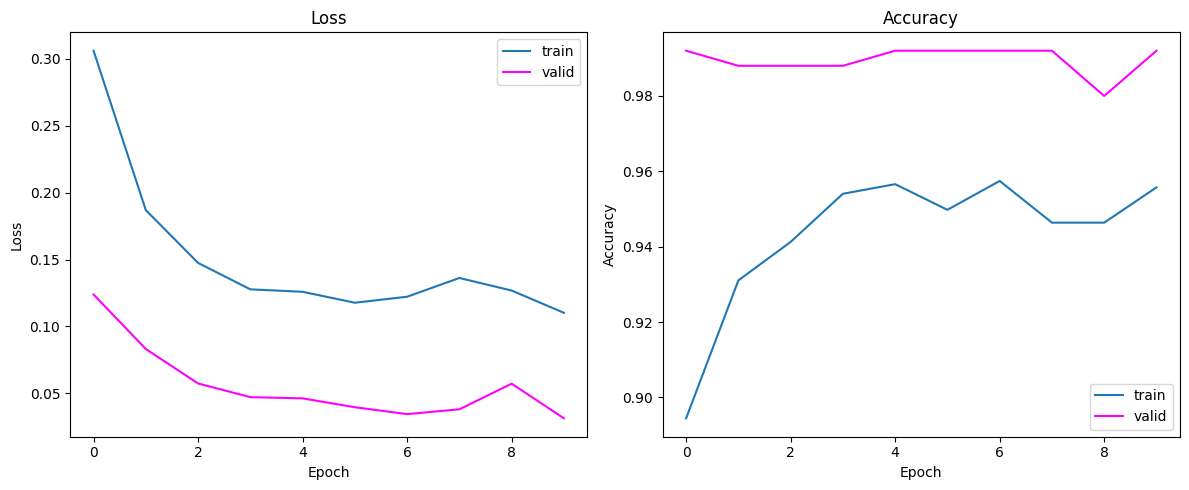

Test accuracy: 0.976
Test F1 Score: 0.980


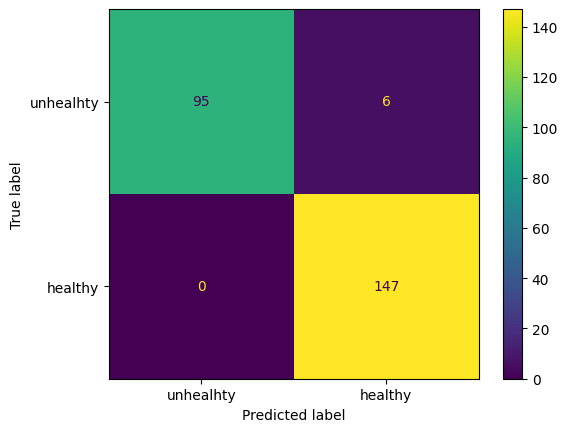

In [21]:
set_seed(42)

resnet_model = CustomResNetModel()
resnet_model = resnet_model.to(device)

criterion = nn.BCEWithLogitsLoss() # code for training loop modified after https://docs.pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html and Computer_vision_exercise_solutions.ipynb
optimizer = torch.optim.Adam(resnet_model.parameters(), lr=0.001)

folder_resnet = './models_resnet_data_augmentation'
os.makedirs(folder_resnet, exist_ok=True)

loss_train, loss_valid, acc_train, acc_val = training_loop_simple(
    num_epochs=10,
    model=resnet_model,
    loaders=loaders,
    loss_f=criterion,
    optimizer=optimizer,
    folder=folder_resnet
)
plot_training_curves(loss_train, loss_valid, acc_train, acc_val)

resnet_model.load_state_dict(torch.load('./models_resnet_data_augmentation/saved_model.pth'))
evaluate(resnet_model, loaders['test'])
cm = evaluate_confusion_matrix(resnet_model, loaders['test'])
cm_plot = ConfusionMatrixDisplay(cm, display_labels=['unhealhty', 'healthy'])
cm_plot.plot()

### Did data augmentation help?

Contrary as expected, data augmentation lead to worse performance for both models, stemming from an increase in false positives (predicting "healthy" while the true label was "unhealthy"). For the LeNet model we observe a drop in test accuracy from 0.956 to 0.927 and a drop in F1 from 0.962 to 0.941. Similarly, for the ResNet model, performance drops from 0.984 to 0.976 in terms of accuracy and from 0.986 to 0.980 regarding the F1 score. Although data augmentation is considered a form of mitigating overfitting (cf. Chollet), the LeNet model is still overfitting and training and validation loss and accuracies are fluctuating heavily. It might be that the transformations applied to the dataset were too extreme (e.g., the rotation of 15 degrees), introducing noise to training and limiting the model's performance during testing on a test set not containing any transformations. 

**Extra**: Any additional discussion and extra work relevant for solving the problem is welcome by the student and will contribute to a better grade.

### Managing overfitting for the LeNet model (imbalanced dataset without data augmentation)

Above, we could observe signs of overfitting for the LeNet model wit ReLU activation function (both with and without data augmentation). Even though the model's performance was quite good (Test accuracy: 0.956, Test F1 Score: 0.962 without data augmentation) and we saved the best model based on decreasing validation loss, it might be worth to experiment with overfitting mitigation strategies to further increase model performance. A typical regularization technqiue used to mitigate overfitting is dropout. The dropout rate specifies what percentage of neurons are zeroed out. Since according to Chollet (2022: 109) it typically ranges from 02. to 0.5, I started with applying a rate of 0.2 after the two first linear layers.

cuda
Size of training data before augmenting: 1978
1978
247
248


100%|██████████| 25/25 [00:00<00:00, 62.52it/s]


Epoch 1
Training Loss: 0.5453, Training Acc: 0.7136
Validation Loss: 0.3890, Validation Acc: 0.8349
-------------------
Validation Loss Decreased (inf --> 0.3890) 	 Saving The Model


100%|██████████| 25/25 [00:00<00:00, 61.98it/s]


Epoch 2
Training Loss: 0.2793, Training Acc: 0.8908
Validation Loss: 0.2077, Validation Acc: 0.9240
-------------------
Validation Loss Decreased (0.3890 --> 0.2077) 	 Saving The Model


100%|██████████| 25/25 [00:00<00:00, 61.60it/s]


Epoch 3
Training Loss: 0.1985, Training Acc: 0.9258
Validation Loss: 0.2834, Validation Acc: 0.8903
-------------------


100%|██████████| 25/25 [00:00<00:00, 61.71it/s]


Epoch 4
Training Loss: 0.1621, Training Acc: 0.9463
Validation Loss: 0.1923, Validation Acc: 0.9303
-------------------
Validation Loss Decreased (0.2077 --> 0.1923) 	 Saving The Model


100%|██████████| 25/25 [00:00<00:00, 56.20it/s]


Epoch 5
Training Loss: 0.1153, Training Acc: 0.9524
Validation Loss: 0.1592, Validation Acc: 0.9440
-------------------
Validation Loss Decreased (0.1923 --> 0.1592) 	 Saving The Model


100%|██████████| 25/25 [00:00<00:00, 59.69it/s]


Epoch 6
Training Loss: 0.0931, Training Acc: 0.9631
Validation Loss: 0.1039, Validation Acc: 0.9640
-------------------
Validation Loss Decreased (0.1592 --> 0.1039) 	 Saving The Model


100%|██████████| 25/25 [00:00<00:00, 59.43it/s]


Epoch 7
Training Loss: 0.1018, Training Acc: 0.9615
Validation Loss: 0.1996, Validation Acc: 0.9400
-------------------


100%|██████████| 25/25 [00:00<00:00, 60.33it/s]


Epoch 8
Training Loss: 0.0773, Training Acc: 0.9773
Validation Loss: 0.2591, Validation Acc: 0.9023
-------------------


100%|██████████| 25/25 [00:00<00:00, 59.61it/s]


Epoch 9
Training Loss: 0.0621, Training Acc: 0.9768
Validation Loss: 0.1842, Validation Acc: 0.9400
-------------------


100%|██████████| 25/25 [00:00<00:00, 59.85it/s]


Epoch 10
Training Loss: 0.0356, Training Acc: 0.9869
Validation Loss: 0.1564, Validation Acc: 0.9463
-------------------
Average training time per epoch on cuda: 5.45 seconds
Total training time: 54.54 seconds


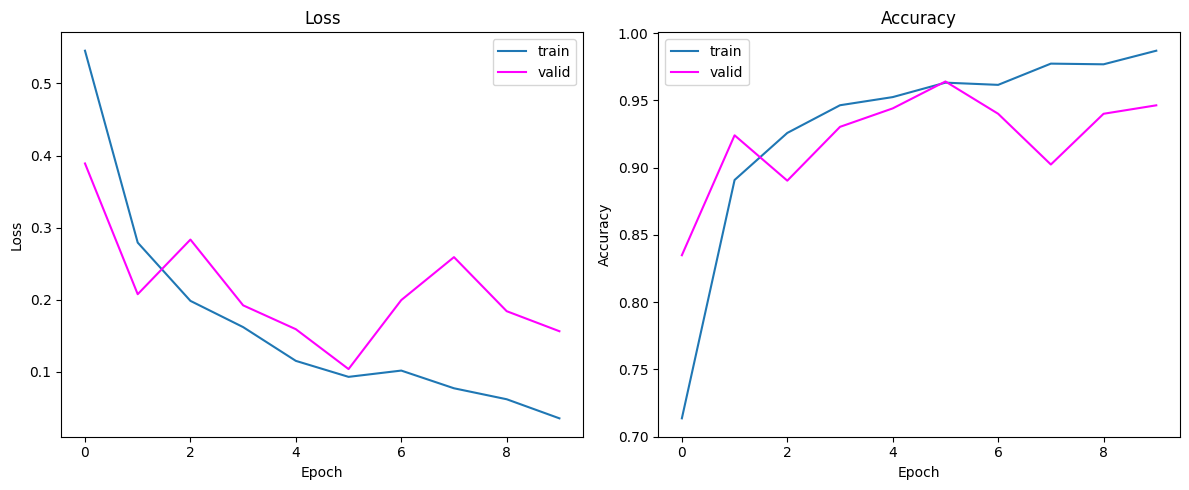

Test accuracy: 0.927
Test F1 Score: 0.940


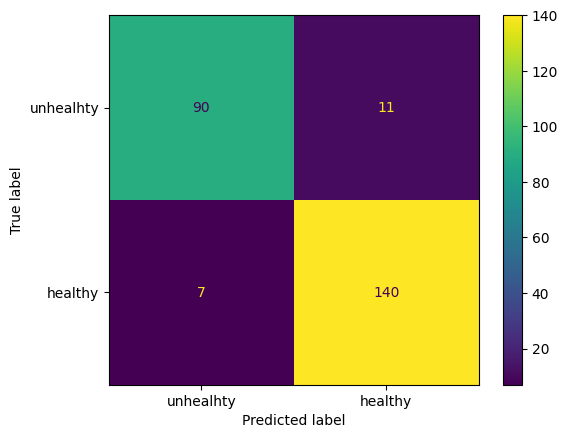

In [22]:
# mitigating overfitting in the baseline LeNet model by applying dropout (LeNet/RELU/NO AUG/DROPOUT)
set_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

baseline_model = nn.Sequential(
    nn.Conv2d(3, 6, kernel_size=5, padding=2),
    nn.ReLU(), # colour image with 3 channels
    nn.AvgPool2d(kernel_size=2, stride=2),

    nn.Conv2d(6, 16, kernel_size=5),
    nn.ReLU(),
    nn.AvgPool2d(kernel_size=2, stride=2),

    nn.Flatten(),

    nn.Linear(16 * 62 * 62, 120),
    nn.ReLU(),
    nn.Dropout(0.2),

    nn.Linear(120, 84),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(84, 1) # binary classification
)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(baseline_model.parameters(), lr=0.001)

folder = './models_baseline_relu_dropout'
os.makedirs(folder, exist_ok=True)

# use not augmented data loaders
# create the datasets (training with oversampling via augmentation to balance classes)
data_train = BellPepperDataset(paths_train, labels_train, transform=transform, transform_augmented=transform_augmented)

print("Size of training data before augmenting:", len(data_train))

# code modified from Computer_vision_exercise_solutions.ipynb
loaders = {
    'train' : torch.utils.data.DataLoader(data_train,
                                        batch_size=10,
                                        shuffle=True,
                                        num_workers=0),

    'validation'  : torch.utils.data.DataLoader(data_eval,
                                        batch_size=10,
                                        shuffle=True,
                                        num_workers=0),
    'test'  : torch.utils.data.DataLoader(data_test,
                                        batch_size=3,
                                        shuffle=False,
                                        num_workers=0),
}

print(len(data_train))
print(len(data_eval))
print(len(data_test))

loss_train, loss_valid, acc_train, acc_val = training_loop_simple(
    num_epochs=10,
    model=baseline_model,
    loaders=loaders,
    loss_f=criterion,
   optimizer=optimizer,
    folder=folder
)

plot_training_curves(loss_train, loss_valid, acc_train, acc_val)

baseline_model.load_state_dict(torch.load('./models_baseline_relu_dropout/saved_model.pth'))
evaluate(baseline_model, loaders['test'])
cm = evaluate_confusion_matrix(baseline_model, loaders['test'])
cm_plot = ConfusionMatrixDisplay(cm, display_labels=['unhealhty', 'healthy'])
cm_plot.plot()

#### Did Dropout help?

Comparing the performance and training cruves of the LeNet model with and without dropout, we can see that the model with dropout shows smoother curves in the first few epochs and the training thus seems more stable. However, the final performance is similar to the model using augmented data (a drop from 0.956 to 0.927 (accuracy) and 0.962 to 0.940 (F1)). This behaviour might be attributed to the shallow architecture of the LeNet model, with dropout potentially limiting the model to exploit its full capacity. Optionally, one could experiment with other dropout values or learning rates. However, it should be noted that a direct comparison is difficult for all experiments. It would have been better to train on different random seeds and average the results to ensure generalizability of the findings.

#### What about a less extreme augmentation transformation?

To evaluate whether a less extreme transformation technique might boost the LeNet model's performance, I decreased the rotation, and changed random vertical flips to horizontal flips.

Size of training data before augmenting: 1978
Augmenting and oversampling dataset by 372 negatives examples.


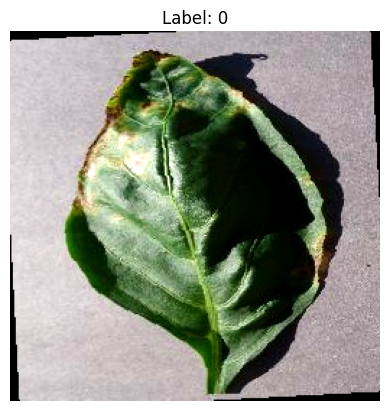

Size of training data after augmenting: 2350
2350
247
248
cuda


100%|██████████| 25/25 [00:00<00:00, 61.28it/s]


Epoch 1
Training Loss: 0.4273, Training Acc: 0.7864
Validation Loss: 0.2440, Validation Acc: 0.8771
-------------------
Validation Loss Decreased (inf --> 0.2440) 	 Saving The Model


100%|██████████| 25/25 [00:00<00:00, 61.03it/s]


Epoch 2
Training Loss: 0.2521, Training Acc: 0.9098
Validation Loss: 0.1783, Validation Acc: 0.9343
-------------------
Validation Loss Decreased (0.2440 --> 0.1783) 	 Saving The Model


100%|██████████| 25/25 [00:00<00:00, 60.24it/s]


Epoch 3
Training Loss: 0.1602, Training Acc: 0.9417
Validation Loss: 0.1851, Validation Acc: 0.9223
-------------------


100%|██████████| 25/25 [00:00<00:00, 61.12it/s]


Epoch 4
Training Loss: 0.1069, Training Acc: 0.9604
Validation Loss: 0.0783, Validation Acc: 0.9640
-------------------
Validation Loss Decreased (0.1783 --> 0.0783) 	 Saving The Model


100%|██████████| 25/25 [00:00<00:00, 60.29it/s]


Epoch 5
Training Loss: 0.0337, Training Acc: 0.9919
Validation Loss: 0.0387, Validation Acc: 0.9800
-------------------
Validation Loss Decreased (0.0783 --> 0.0387) 	 Saving The Model


100%|██████████| 25/25 [00:00<00:00, 60.37it/s]


Epoch 6
Training Loss: 0.0537, Training Acc: 0.9821
Validation Loss: 0.0648, Validation Acc: 0.9800
-------------------


100%|██████████| 25/25 [00:00<00:00, 54.85it/s]


Epoch 7
Training Loss: 0.0187, Training Acc: 0.9940
Validation Loss: 0.1737, Validation Acc: 0.9600
-------------------


100%|██████████| 25/25 [00:00<00:00, 61.66it/s]


Epoch 8
Training Loss: 0.0433, Training Acc: 0.9830
Validation Loss: 0.1247, Validation Acc: 0.9680
-------------------


100%|██████████| 25/25 [00:00<00:00, 61.04it/s]


Epoch 9
Training Loss: 0.0111, Training Acc: 0.9966
Validation Loss: 0.7128, Validation Acc: 0.8503
-------------------


100%|██████████| 25/25 [00:00<00:00, 61.56it/s]


Epoch 10
Training Loss: 0.1954, Training Acc: 0.9362
Validation Loss: 0.1666, Validation Acc: 0.9566
-------------------
Average training time per epoch on cuda: 5.96 seconds
Total training time: 59.61 seconds


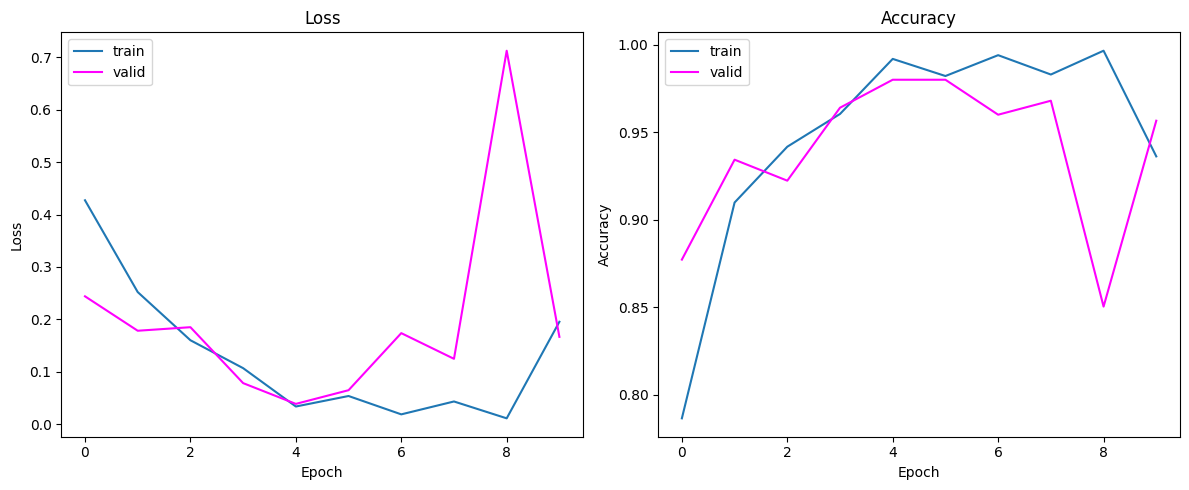

Test accuracy: 0.948
Test F1 Score: 0.957


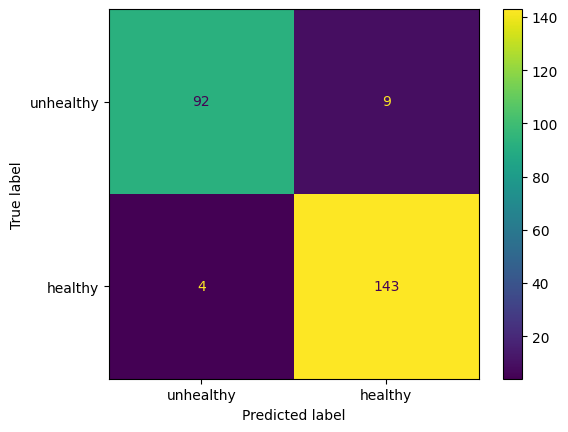

In [24]:
# LeNet/RELU/MORE_EXTREME_AUG, to compare with LeNet/RELU/AUG

transform_augmented_less_extreme = transforms.Compose([ # see PRACTICE_1_image_augmentation_torch.ipynb
    transforms.RandomRotation(degrees=5),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
])

set_seed(42)

# create the datasets (training with oversampling via augmentation to balance classes)
data_train = BellPepperDataset(paths_train, labels_train, transform=transform, transform_augmented=transform_augmented_less_extreme)

print("Size of training data before augmenting:", len(data_train))

# data augmentation for training set
data_train.oversample_minority_class_by_augmenting()

image, label = data_train[len(data_train)-1] # have a look at one augmented image (unhealthy bell pepper)
plt.imshow(TF.to_pil_image(image))
plt.title(f"Label: {label}")
plt.axis("off")
plt.show()

print("Size of training data after augmenting:", len(data_train))

# code modified from Computer_vision_exercise_solutions.ipynb
loaders = {
    'train' : torch.utils.data.DataLoader(data_train,
                                        batch_size=10,
                                        shuffle=True,
                                        num_workers=0),

    'validation'  : torch.utils.data.DataLoader(data_eval,
                                        batch_size=10,
                                        shuffle=True,
                                        num_workers=0),
    'test'  : torch.utils.data.DataLoader(data_test,
                                        batch_size=3,
                                        shuffle=False,
                                        num_workers=0),
}

print(len(data_train))
print(len(data_eval))
print(len(data_test))


set_seed(42)

baseline_model = nn.Sequential(
    nn.Conv2d(3, 6, kernel_size=5, padding=2), nn.ReLU(), # colour image with 3 channels
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.ReLU(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(16 * 62 * 62, 120), nn.ReLU(),
    nn.Linear(120, 84), nn.ReLU(),
    nn.Linear(84, 1) # binary classification
)


criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(baseline_model.parameters(), lr=0.001)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

folder = './models_baseline_relu_less_extreme_aug'
os.makedirs(folder, exist_ok=True)

loss_train, loss_valid, acc_train, acc_val = training_loop_simple(
    num_epochs=10,
    model=baseline_model,
    loaders=loaders,
    loss_f=criterion,
   optimizer=optimizer,
    folder=folder
)

plot_training_curves(loss_train, loss_valid, acc_train, acc_val)


baseline_model.load_state_dict(torch.load('./models_baseline_relu_less_extreme_aug/saved_model.pth'))
evaluate(baseline_model, loaders['test'])
cm = evaluate_confusion_matrix(baseline_model, loaders['test'])
cm_plot = ConfusionMatrixDisplay(cm, display_labels=['unhealthy', 'healthy'])
cm_plot.plot()

When applying a less extreme augmentation strategy it can be observed that the model with the less extreme transformations achieves slightly higher performance (increase in accuracy from 0.927 to 0.948, and an increase in F1 from 0.941 to 0.957) and false negatives decrease. This indicates that a less aggressive augmentation strategy benefits the performance, leading to oversampling of the minority class with images that do not diverge too much from their originals and therefore introducing less noise. Nevertheless, the performance of the model with no augmentation is still slighlty higher (accuracy of 0.956 and F1 of 0.962), suggesting that the LeNet model already generalizes well to the original dataset. This might be due to the simplicity of distinguishing healthy from unhealhty leaves, diminishing the benefits of a more balanced dataset with more variation. 

### Final analysis:

In conclusion, even though training time is doubled, fine-tuning the classification head of a pre-trained ResNet50 model yielded higher performance than training a LeNet model from scratch. This highlights that the ResNet50 model learned rich features during pre-training that boosted performance for the dataset at hand.

Contrary to my expectations, data augmentation lead to slighlty worse performance for both models. This was argued to be due to a potentially too aggressive transformation strategy used to augment the minority class images in order to balance the dataset. A slightly less changing transformation reduced in slightly better results compared to the more aggressive strategy, however, the LeNet model still performed better without augmentation. It would be intersting to see whether this trend is also observable for the ResNet50 model. 

However, it must be noted that the results should be interpreted with caution since the experiments were only performed on one random seed/one run. To achieve greater robustness and generalizability of the findings, one could run them on more random seeds and average the results. 

Furthermore, while the learning rate was manually fine-tuned, the batch sizes and other hyperparameters were adopted from the notebook Computer_vision_exercise_solutions.ipynb since they treated a similar classification problem. It would have been better to fine tune hyperparameters with Optuna to find the optimal values and increase performace. Moreover, to further improve the performance of the ResNet50 model one could further unfreeze more layers to fine-tune them as well. Even though performances were high (above 90% and close to 100% for some models and experiments), another consideration is to use normalization as a data preprocessing step, as it reduces differences in magnitude in the input and could lead to more stable training (cf. Huang et al. 2023) . For ResNet models for example, it is recommended to use specific normalization stats (cf. https://pytorch.org/hub/pytorch_vision_resnet/, accessed Aug 6, 2025).

### References

Chollet, F. (2021). Deep learning with Python. simon and schuster.

Géron, A. (2022). Hands-on machine learning with Scikit-Learn, Keras, and
TensorFlow. " O'Reilly Media, Inc.".

He, K., Zhang, X., Ren, S., & Sun, J. (2016). Deep residual learning for image recognition. In Proceedings of the IEEE conference on computer vision and pattern recognition (pp. 770-778).

LeCun, Y., Bottou, L., Bengio, Y., & Haffner, P. (2002). Gradient-based learning applied to document recognition. Proceedings of the IEEE, 86(11), 2278-2324.

Huang, L., Qin, J., Zhou, Y., Zhu, F., Liu, L., & Shao, L. (2023). Normalization techniques in training dnns: Methodology, analysis and application. IEEE transactions on pattern analysis and machine intelligence, 45(8), 10173-10196.